In [4]:
%load_ext autoreload
%autoreload 2
from typing import List

import os
from copy import copy
from itertools import combinations, permutations
import pickle
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')

In [5]:
from cube import Cube3D

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

We try to address the 3rd question from the previous notebook.

## Define the target for the greedy algorithm
What 'sort loss' function we use for a rubik's cube?

$$
\text{SL} = \sum_{i=1}^{n-1} \sum_{j=i+1}^{n} [x_i > x_j]
$$

Maybe stick to this one? With only difference in excluding zeroes (for the rubik's cube case)

In [252]:
cube = Cube3D(3)

In [253]:
cube.cube

array([[[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9]],

       [[10, 11, 12],
        [13,  0, 15],
        [16, 17, 18]],

       [[19, 20, 21],
        [22, 23, 24],
        [25, 26, 27]]])

In [254]:
cube.sort_loss()

0

How we define this group's actions?

Each side has a pattern of [1 2 3 4 5 6 7 8] -> [7 8 1 2 3 4 5 6]

|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|
|-|-|-|-|-|-|-|-|-|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|


4 possible action types:

I.

|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|
|-|-|-|-|-|-|-|-|-|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|<span style="color:blue">c</span>|<span style="color:blue">d</span>|<span style="color:blue">e</span>|<span style="color:blue">f</span>|<span style="color:blue">g</span>|<span style="color:blue">h</span>|<span style="color:blue">a</span>|<span style="color:blue">b</span>|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|

II.

|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|
|-|-|-|-|-|-|-|-|-|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|a|b|c|d|e|f|g|h|<span style="color:blue">k</span>|<span style="color:blue">l</span>|<span style="color:blue">m</span>|<span style="color:blue">n</span>|<span style="color:blue">o</span>|<span style="color:blue">p</span>|<span style="color:blue">i</span>|<span style="color:blue">j</span>|q|r|s|t|u|v|w|x|

III.

|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|
|-|-|-|-|-|-|-|-|-|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|a|b||d|e|f|g||i|j||l|m|n|o||||||u|v|w|x|

IV.

|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|
|-|-|-|-|-|-|-|-|-|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|a|b|c||e|f||h|i|j|k||m|n||p|q|r|s|t|||||

The train data can be easily generated for the greedy algorithm and fixed sequence length as the most optimal action in terms of previously defined 'sort loss':

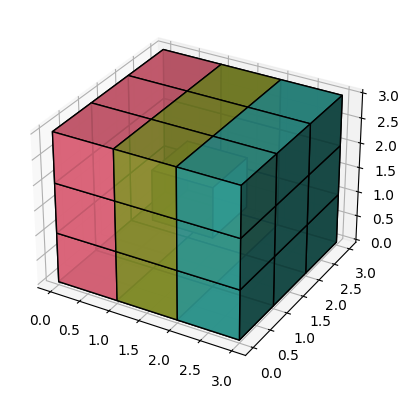

In [257]:
cube.plot()

In [258]:
cube.cube

array([[[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9]],

       [[10, 11, 12],
        [13,  0, 15],
        [16, 17, 18]],

       [[19, 20, 21],
        [22, 23, 24],
        [25, 26, 27]]])

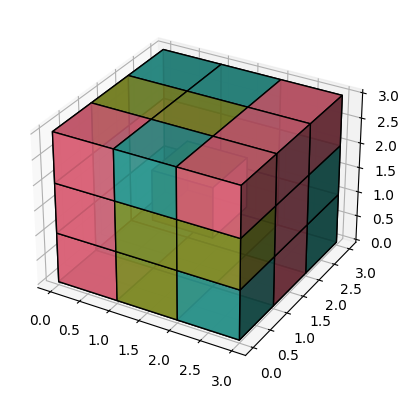

In [266]:
cube.mix(100)
cube.plot()

In [267]:
cube.sort_loss()

176

## Prepare train data

Input - reshaped to 1-D array cube. <br>
Output - best next action in terms of sort loss optimization (including "ideal"). <br><br>

Output can be assessed as the best next step, best next step leading to better second next step and so on. <br>
So we will try:
- 1 step
- 2 step
- 3 step
optimizations.

In [74]:
# generate simple data
from copy import deepcopy
import pickle
import random


def generate_data(dataset_size, num_steps):
    DATA = []
    cube = Cube3D(2)
    output_array_size = len(cube.get_actions_possible().keys())
    for i in range(dataset_size):
        if i%100 == 0:
            print(f'{i} lines generated.')
        cube.mix(random.randint(0, 50))
        init_loss = cube.sort_loss()
        best_action = 0
        for actions in list(set(permutations(list(cube.get_actions_possible().keys())*num_steps, num_steps))):
            cp_cube = deepcopy(cube)
            for action in actions:
                cp_cube.apply_action(action)
            new_loss = cp_cube.sort_loss()
            if new_loss < init_loss:
                init_loss = new_loss
                best_action = actions[0]
        output = [0]*output_array_size
        output[best_action] = 1
        DATA.append((deepcopy(cube), output))
    return DATA


def split_data(data, split_rate=0.9):
    train_data = []
    test_data = []
    for row in data:
        input_data = row[0].flattened
        if random.random() < split_rate:
            train_data.append([input_data, row[1]])
        else:
            test_data.append([input_data, row[1]])
    return train_data, test_data


def dump_data(train_data, test_data, dataset_size, num_steps, split_rate, prefix=''):
    with open(f'../data/{prefix}_{num_steps}_{dataset_size}_{split_rate}_train.pkl', 'wb') as f:
        pickle.dump(train_data, f)
    with open(f'../data/{prefix}_{num_steps}_{dataset_size}_{split_rate}_test.pkl', 'wb') as f:
        pickle.dump(test_data, f)


def load_data(dataset_size, num_steps, split_rate, prefix=''):
    with open(f'../data/{prefix}_{num_steps}_{dataset_size}_{split_rate}_train.pkl', 'rb') as f:
        train_data = pickle.load(f)

    with open(f'../data/{prefix}_{num_steps}_{dataset_size}_{split_rate}_test.pkl', 'rb') as f:
        test_data = pickle.load(f)

    return train_data, test_data


## 1 step optimization

In [12]:
# v1 is a simple attempt of using defined convex sort loss and 1/2/3 steps optimization.

DATASET_SIZE = 1000
STEPS = 2
SPLIT_RATE = 0.9
PREFIX = 'v0'

try:
    train_data, test_data = load_data(DATASET_SIZE, STEPS, SPLIT_RATE, PREFIX)
except:
    data = generate_data(DATASET_SIZE, STEPS)
    train_data, test_data = split_data(data, SPLIT_RATE)
    dump_data(train_data, test_data, DATASET_SIZE, STEPS, SPLIT_RATE, PREFIX)

0 lines generated.
100 lines generated.
200 lines generated.
300 lines generated.
400 lines generated.
500 lines generated.
600 lines generated.
700 lines generated.
800 lines generated.
900 lines generated.


In [75]:
class SorterNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(SorterNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


In [76]:
def run_testbed(cube_size, dataset_size, steps, split_rate, prefix, hidden_size, random_step_prob):
    try:
        train_data, test_data = load_data(dataset_size, steps, split_rate, prefix)
    except:
        data = generate_data(dataset_size, steps)
        train_data, test_data = split_data(data, split_rate)
        dump_data(train_data, test_data, dataset_size, steps, split_rate, prefix)
    # prepare model
    input_train_data = torch.tensor([x[0] for x in train_data], dtype=torch.float32)
    output_train_data = torch.tensor([x[1] for x in train_data], dtype=torch.float32)
    PATH = f'../models/{cube_size}_{prefix}_{steps}_{dataset_size}_{split_rate}_h{hidden_size}_model.pkl'
    input_size = input_train_data.shape[1]
    output_size = output_train_data.shape[1]
    model = None
    if not os.path.exists(PATH):
        if prefix == 'greedy_v1':
            model = SorterNN(input_size, hidden_size, output_size)
        else:
            raise ValueError('Unknown test prefix.')
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 5000
        for epoch in range(num_epochs):
            outputs = model(input_train_data)
            loss = criterion(outputs, output_train_data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        torch.save(model.state_dict(), PATH)
    else:
        model = SorterNN(input_size, hidden_size, output_size)
        model.load_state_dict(torch.load(PATH))
        model.eval()
    # evaluate
    RES = {
        'train_errors': None,
        'train_mistakes': None,
        'test_errors': None,
        'test_mistakes': None,
        'sort_stats': None,
    }
    test_wrong = 0
    test_errors = 0
    for test_row in test_data:
        test_input = torch.tensor([test_row[0]], dtype=torch.float32)
        predicted_output = model(test_input).round()
        try:
            if test_row[1].index(1) != predicted_output.detach().numpy()[0].tolist().index(1):
                test_wrong += 1
        except:
            test_errors += 1
    train_wrong = 0
    train_errors = 0
    for test_row in train_data:
        test_input = torch.tensor([test_row[0]], dtype=torch.float32)
        predicted_output = model(test_input).round()
        try:
            if test_row[1].index(1) != predicted_output.detach().numpy()[0].tolist().index(1):
                train_wrong += 1
        except:
            train_errors += 1
    # test the sorting
    max_iter = 100000
    sort_stats = {
        'max_iter': [],
        'init_loss': [],
        'output_loss': [],
    }
    for t in range(100):
        print(t)
        cube = Cube3D(cube_size)
        cube.mix(100)
        init_loss = cube.sort_loss()
        v = cube.sort_loss()
        i = 0
        while True:
            test_input = torch.tensor([cube.flattened], dtype=torch.float32)
            predicted_output = model(test_input)
            try:
                if random.random() < random_step_prob:
                    action = predicted_output.detach().numpy().astype(int).tolist()[0].index(1)
                else:
                    action = random.randint(0, len(cube.action_keys)-1)
            except:
                action = random.randint(0, len(cube.action_keys)-1)
            cube.apply_action(action)
            v = cube.sort_loss()
            i += 1
            if i > max_iter or v == 0:
                sort_stats['init_loss'].append(init_loss)
                sort_stats['max_iter'].append(i)
                sort_stats['output_loss'].append(v)
                break
    RES['train_errors'] = train_errors
    RES['train_mistakes'] = train_wrong
    RES['test_errors'] = test_errors
    RES['test_mistakes'] = test_wrong
    RES['sort_stats'] = sort_stats
    return RES
    

In [86]:
TESTS = []

CUBE_SIZES = [2]
DATASET_SIZES = [500, 1000, 5000, 10000]
STEPS = [1, 2, 3]
SPLIT_RATES = [0.9]
PREFIXES = ['greedy_v1']
HIDDEN_SIZES = [64]
RANDOM_STEP_PROBS = [0.5, 0.7, 0.9, 0.95]

for cube_size in CUBE_SIZES:
    for dataset_size in DATASET_SIZES:
        for step in STEPS:
            for split_rate in SPLIT_RATES:
                for prefix in PREFIXES:
                    for hidden_size in HIDDEN_SIZES:
                        for random_step_prob in RANDOM_STEP_PROBS:
                            TESTS.append(
                                {
                                    'cube_size': cube_size,
                                    'dataset_size': dataset_size,
                                    'step': step,
                                    'split_rate': split_rate,
                                    'prefix': prefix,
                                    'hidden_size': hidden_size,
                                    'random_step_prob': random_step_prob,
                                }
                            )

In [87]:
len(TESTS)

48

In [153]:
RESULTS = {
    'cube_size': [],
    'dataset_size': [],
    'step': [],
    'split_rate': [],
    'prefix': [],
    'hidden_size': [],
    'random_step_prob': [],
    'train_errors': [],
    'train_mistakes': [],
    'test_errors': [],
    'test_mistakes': [],
    'median_max_iter': [],
    'median_init_loss': [],
    'median_output_loss': [],
    'failed_to_sort': [],
}
for ti, TEST in enumerate(TESTS):
    print(f'--------------------test number {ti}---------------\n')
    cube_size = TEST['cube_size']
    dataset_size = TEST['dataset_size']
    step = TEST['step']
    split_rate = TEST['split_rate']
    prefix = TEST['prefix']
    hidden_size = TEST['hidden_size']
    random_step_prob = TEST['random_step_prob']
    TEST_RESULTS_PATH = f'../test_results/cube{cube_size}_{dataset_size}_{step}_{split_rate}_{prefix}_{hidden_size}_{random_step_prob}.pkl'

    RES = None
    if os.path.exists(TEST_RESULTS_PATH):
        with open(TEST_RESULTS_PATH, 'rb') as f:
            RES = pickle.load(f)
    else:
        RES = run_testbed(cube_size, dataset_size, step, split_rate, prefix, hidden_size, random_step_prob)
        with open(TEST_RESULTS_PATH, 'wb') as f:
            pickle.dump(RES, f)
    RESULTS['cube_size'].append(cube_size)
    RESULTS['dataset_size'].append(dataset_size)
    RESULTS['step'].append(step)
    RESULTS['split_rate'].append(split_rate)
    RESULTS['prefix'].append(prefix)
    RESULTS['hidden_size'].append(hidden_size)
    RESULTS['random_step_prob'].append(random_step_prob)
    RESULTS['train_errors'].append(RES['train_errors'])
    RESULTS['train_mistakes'].append(RES['train_mistakes'])
    RESULTS['test_errors'].append(RES['test_errors'])
    RESULTS['test_mistakes'].append(RES['test_mistakes'])
    RESULTS['median_max_iter'].append(sorted(RES['sort_stats']['max_iter'])[len(RES['sort_stats']['max_iter'])//2])
    RESULTS['median_init_loss'].append(sorted(RES['sort_stats']['init_loss'])[len(RES['sort_stats']['init_loss'])//2])
    RESULTS['median_output_loss'].append(sorted(RES['sort_stats']['output_loss'])[len(RES['sort_stats']['output_loss'])//2])
    RESULTS['failed_to_sort'].append(len(list(filter(lambda x: x > 100000 - 1, RES['sort_stats']['max_iter']))))
    print('\n\n')


In [130]:
pd.DataFrame(RES['sort_stats']).sort_values(by='max_iter', ascending=True)

,max_iter,init_loss,output_loss
63,6,18,0
65,59,16,0
56,72,16,0
28,86,16,0
44,132,20,0
...,...,...,...
61,5691,10,0
91,5833,14,0
24,6486,16,0
74,7125,12,0


In [93]:
df = pd.DataFrame(RESULTS).sort_values(by='median_max_iter')
df

,cube_size,dataset_size,step,split_rate,prefix,hidden_size,random_step_prob,train_errors,train_mistakes,test_errors,test_mistakes,median_max_iter,median_init_loss,median_output_loss,failed_to_sort
46,2,10000,3,0.9,greedy_v1,64,0.90,22,4991,2,611,1245,14,0,0
41,2,10000,2,0.9,greedy_v1,64,0.70,12,2695,2,328,1646,12,0,0
45,2,10000,3,0.9,greedy_v1,64,0.70,22,4991,2,611,1714,14,0,0
47,2,10000,3,0.9,greedy_v1,64,0.95,22,4991,2,611,1782,14,0,0
18,2,1000,2,0.9,greedy_v1,64,0.90,24,251,1,45,1942,14,0,0
42,2,10000,2,0.9,greedy_v1,64,0.90,12,2695,2,328,1957,16,0,0
19,2,1000,2,0.9,greedy_v1,64,0.95,24,251,1,45,1998,14,0,0
22,2,1000,3,0.9,greedy_v1,64,0.90,22,417,0,73,2047,14,0,0
28,2,5000,2,0.9,greedy_v1,64,0.50,13,1405,0,193,2049,14,0,0
30,2,5000,2,0.9,greedy_v1,64,0.90,13,1405,0,193,2131,14,0,0


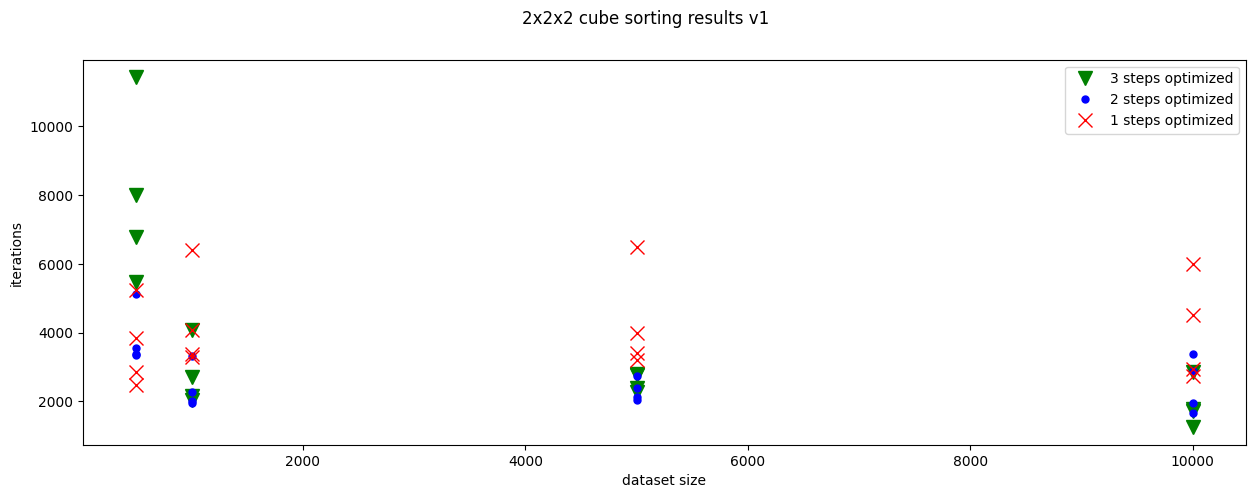

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

plots = [
    (3, 0.5, 'vg'),
    (3, 0.7, 'vg'),
    (3, 0.9, 'vg'),
    (3, 0.95, 'vg'),
    (2, 0.5, '.b'),
    (2, 0.7, '.b'),
    (2, 0.9, '.b'),
    (2, 0.95, '.b'),
    (1, 0.5, 'xr'),
    (1, 0.7, 'xr'),
    (1, 0.9, 'xr'),
    (1, 0.95, 'xr'),
]

for i, (step, rs_prob, marker) in enumerate(plots):
    df1 = df.loc[(df['step'] == step) & (df['random_step_prob'] == rs_prob)]
    label = None
    if (i+1)%4==0:
        label = f'{step} steps optimized'
    ax.plot(df1['dataset_size'], df1['median_max_iter'], marker, label=label, markersize=10)

plt.xlabel('dataset size')
plt.ylabel('iterations')
plt.suptitle('2x2x2 cube sorting results v1')
plt.legend()

In [90]:
# todo:
# - concentric dataset (100% data close to (0, 0), and less after)
# - deep search data